# Hypothesis 1: Shift in Tipping Culture

#### We attempt to answer the question: **After adjusting for confounding factors such as trip duration and surcharges, do customers in 2019 exhibit different tipping behavior than those in 2014?**

In [60]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/taxidata_clean.csv', parse_dates=['trip_start_timestamp'])
df['year'] = df['trip_start_timestamp'].dt.year
df['pct_tip'] = 100 * df['tips'] / df['fare'].replace(0, np.nan)
df['hour'] = df['trip_start_timestamp'].dt.hour
df['dow'] = df['trip_start_timestamp'].dt.dayofweek
df['speed_mph'] = 3600 * df['trip_miles'] / df['trip_seconds'].replace(0, np.nan)

# 1. Exploratory Data Analysis and additional Preprocessing

As seen below, the dataset seemingly did not include any cash tips, as most tips came from riders who paid using credit card.

In [61]:
c = df.assign(has_tip=df['tips']>0).groupby(['year','payment_type']).agg(
    n=('tips','count'), n_tips=('has_tip','sum')
).assign(pct_tipped=lambda x: 100*x['n_tips']/x['n'])
print('2014:'); display(c.loc[2014])
print('2019:'); display(c.loc[2019])

2014:


,n,n_tips,pct_tipped
payment_type,,,
Cash,128779,1,0.0008
Credit Card,68575,66225,96.5731
Dispute,150,0,0.0000
No Charge,1483,0,0.0000
Unknown,295,113,38.3051


2019:


,n,n_tips,pct_tipped
payment_type,,,
Cash,93679,46,0.0491
Credit Card,98698,94319,95.5632
Dispute,69,0,0.0000
Mobile,3480,3433,98.6494
No Charge,319,5,1.5674
Pcard,2,0,0.0000
Prcard,2085,158,7.5779
Prepaid,9,0,0.0000
Unknown,1314,39,2.9680


Text(0, 0.5, 'Density')

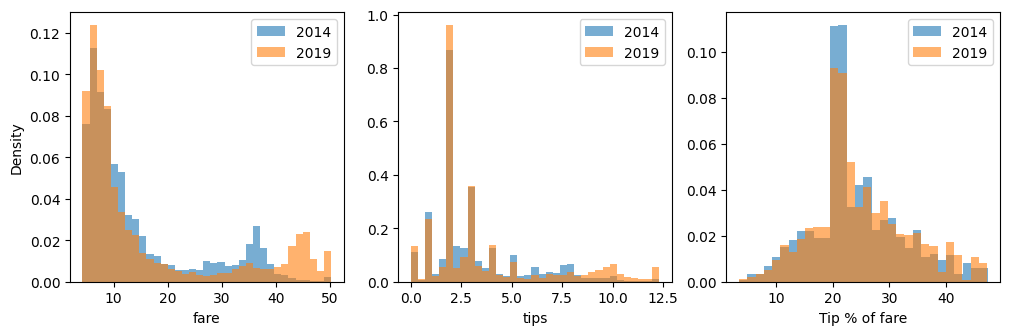

In [62]:
# CC users only: fare, tip, and tip % distributions, 2014 vs 2019
cc = df[(df['payment_type']=='Credit Card') & (df['fare']>0)].copy()
cc_pct = cc[cc['tips']>0][['year','pct_tip']].dropna()
q1, q3 = cc_pct['pct_tip'].quantile([0.25, 0.75])
cc_pct = cc_pct[(cc_pct['pct_tip']>=q1-1.5*(q3-q1)) & (cc_pct['pct_tip']<=q3+1.5*(q3-q1))]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
for col, ax_ in zip(['fare', 'tips'], ax[:2]):
    for y in [2014, 2019]:
        s = cc[cc['year']==y][col].clip(cc[col].quantile(0.01), cc[col].quantile(0.99))
        ax_.hist(s, bins=35, alpha=0.6, label=y, density=True)
    ax_.set_xlabel(col); ax_.legend()
for y in [2014, 2019]:
    ax[2].hist(cc_pct[cc_pct['year']==y]['pct_tip'], bins=30, alpha=0.6, label=y, density=True)
ax[2].set_xlabel('Tip % of fare'); ax[2].legend()
ax[0].set_ylabel('Density')

### Speed: 2014 vs 2019

Speed (mph) = trip_miles / (trip_seconds/3600). Trips with trip_seconds ≤ 0 excluded.

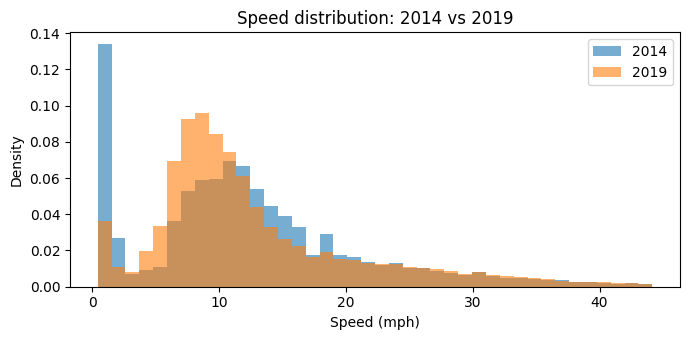

2014: mean=12.35 mph, median=11.22
2019: mean=12.74 mph, median=10.34


In [63]:
sp = df[df['trip_seconds']>0][['year','speed_mph']].dropna()
sp = sp[sp['speed_mph'].between(sp['speed_mph'].quantile(0.01), sp['speed_mph'].quantile(0.99))]

fig, ax = plt.subplots(figsize=(7, 3.5))
for y in [2014, 2019]:
    ax.hist(sp[sp['year']==y]['speed_mph'], bins=40, alpha=0.6, label=y, density=True)
ax.set_xlabel('Speed (mph)'); ax.set_ylabel('Density'); ax.legend()
ax.set_title('Speed distribution: 2014 vs 2019')
plt.tight_layout(); plt.show()

y14, y19 = sp[sp['year']==2014]['speed_mph'], sp[sp['year']==2019]['speed_mph']
print(f'2014: mean={y14.mean():.2f} mph, median={y14.median():.2f}')
print(f'2019: mean={y19.mean():.2f} mph, median={y19.median():.2f}')

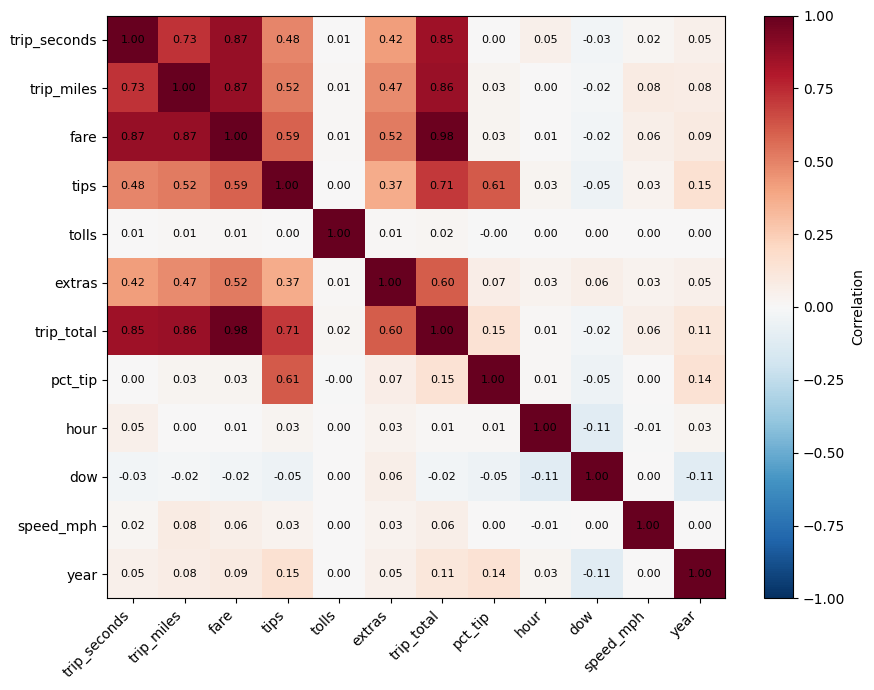

In [64]:
num_cols = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'pct_tip', 'hour', 'dow', 'speed_mph', 'year']
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticklabels(num_cols)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f'{corr.iloc[i,j]:.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

To choose confouding factors, we take a look at the available variables and decide on the `trip_seconds`, `trip_miles`, `fare`, `extras` and `speed_mph`.

### Preprocessing validation: confounding variables

Check that `trip_seconds`, `trip_miles`, `fare`, `extras`, `speed_mph` are valid for the analysis subset (CC, fare>0). Drop invalid rows. Use `df_cc` for subsequent modeling.

In [65]:
confound_cols = ['trip_seconds', 'trip_miles', 'fare', 'extras', 'speed_mph']
mask_cc = (df['payment_type'] == 'Credit Card') & (df['fare'] > 0)
df_cc = df[mask_cc].copy()

print('Validity checks (CC, fare>0):')
for c in confound_cols:
    n_na = df_cc[c].isna().sum()
    n_neg = (df_cc[c] < 0).sum()
    n_zero = (df_cc[c] == 0).sum() if c != 'extras' else 'N/A' 
    print(f'  {c:14s}: NaN={n_na:,}, neg={n_neg:,}', end='')
    if c != 'extras':
        print(f', zero={n_zero:,}')
    else:
        print()

# Additional filters: drop rows with invalid confounding vars
valid = (
    (df_cc['trip_seconds'] > 0) &
    (df_cc['trip_miles'] > 0) &
    (df_cc['fare'] > 0) &
    (df_cc['extras'] >= 0) &
    (df_cc['speed_mph'].notna()) &
    (df_cc['speed_mph'] > 0) &
    (df_cc['speed_mph'] <= 100)
)
dropped = df_cc[~valid]
df_cc = df_cc[valid]
n_drop = len(dropped)
print(f'\nDropped {n_drop} rows with invalid confounders. Final n={len(df_cc):,}')

Validity checks (CC, fare>0):
  trip_seconds  : NaN=0, neg=0, zero=0
  trip_miles    : NaN=0, neg=0, zero=0
  fare          : NaN=0, neg=0, zero=0
  extras        : NaN=0, neg=0
  speed_mph     : NaN=0, neg=0, zero=0

Dropped 32 rows with invalid confounders. Final n=167,241


# 2. Methodology

## Global Test — Doubly Robust Local Permutation

We test the global null hypothesis:

$$H_0: \text{Year} \perp \text{tips} \mid Z = (\text{fare, extras, trip\_seconds, trip\_miles, speed\_mph})$$

**Steps:**
1. Fit OLS **without** year: `tips ~ fare + extras + trip_seconds + trip_miles + speed_mph`. Compute residuals $\hat{r}_i$.
2. Test statistic: $T = \bar{\hat{r}}_{2019} - \bar{\hat{r}}_{2014}$
3. Create bins by 10% quantiles of fare (10 bins). Permute year labels within each bin to generate null distribution.
4. Two-sided p-value with $+1/+1$ correction.

### Step 1: Outcome regression (no year)

In [92]:
import statsmodels.api as sm
from scipy import stats

SEED = 42
M_PERM = 1000
ALPHA = 0.05
rng = np.random.default_rng(SEED)

df_cc['year_dummy'] = (df_cc['year'] == 2019).astype(int)
CONFOUNDERS = ['fare', 'extras', 'trip_seconds', 'trip_miles', 'speed_mph']

# ── Step 1: OLS WITHOUT year ──
X_no_year = df_cc[CONFOUNDERS].copy()
X_no_year.insert(0, 'const', 1.0)
Y = df_cc['tips'].values

ols_no_year = sm.OLS(Y, X_no_year).fit()
df_cc['residual'] = ols_no_year.resid

# ── Bins: 10% quantiles of fare ──
fare_deciles = pd.qcut(df_cc['fare'], q=10, labels=False, duplicates='drop')
bin_labels = np.array([f'D{int(x):02d}' for x in fare_deciles + 1])
df_cc['perm_bin'] = pd.Categorical(bin_labels, categories=sorted(np.unique(bin_labels)), ordered=True)

print(ols_no_year.summary())
print(f"\nNumber of bins: {df_cc['perm_bin'].nunique()}")
print(f"\nObservations per bin:")
bin_counts = df_cc.groupby('perm_bin', observed=True).agg(
    n=('year_dummy', 'count'),
    n_2014=('year_dummy', lambda x: (x == 0).sum()),
    n_2019=('year_dummy', 'sum')
).assign(p_2019=lambda x: x['n_2019'] / x['n']).sort_index(ascending=True)
print(bin_counts.to_string())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                 7.194e+04
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:16:30   Log-Likelihood:            -3.1837e+05
No. Observations:              167241   AIC:                         6.368e+05
Df Residuals:                  167235   BIC:                         6.368e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8246      0.012     66.259   

### Visual assumption checks: regression & exchangeability

/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


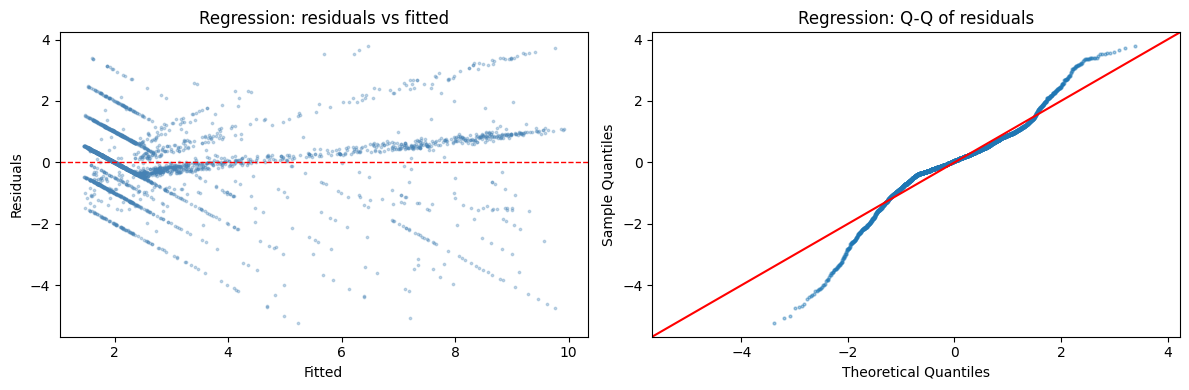

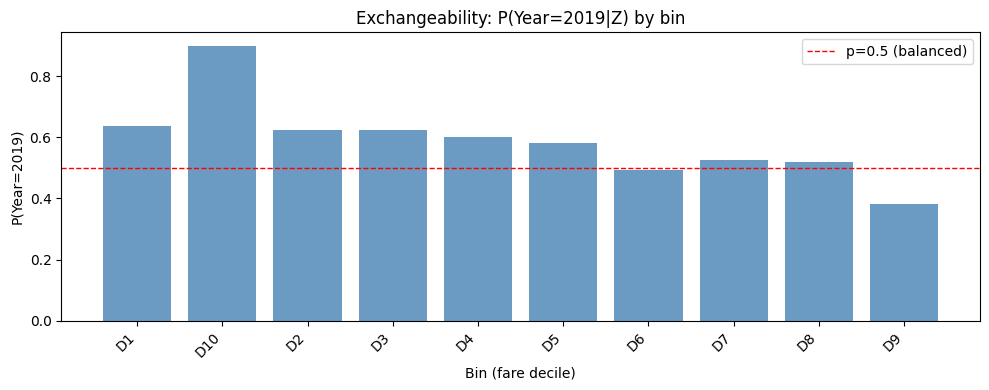

In [102]:
# ── Brief visual checks: regression & exchangeability ──

# Subsample and limit outliers for clearer visualization
resid, fitted = ols_no_year.resid.values, ols_no_year.fittedvalues.values
idx = np.random.RandomState(SEED).choice(len(resid), size=min(3000, len(resid)), replace=False)
r, f = resid[idx], fitted[idx]
# Clip to 1st–99th percentile to reduce outlier dominance
r_lo, r_hi = np.percentile(r, 1), np.percentile(r, 99)
f_lo, f_hi = np.percentile(f, 1), np.percentile(f, 99)
mask = (r >= r_lo) & (r <= r_hi) & (f >= f_lo) & (f <= f_hi)
r_plot, f_plot = r[mask], f[mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Regression: residuals vs fitted & Q-Q
axes[0].scatter(f_plot, r_plot, s=3, alpha=0.3, color='steelblue')
axes[0].axhline(0, color='red', ls='--', lw=1)
axes[0].set_xlabel('Fitted'); axes[0].set_ylabel('Residuals')
axes[0].set_title('Regression: residuals vs fitted')

# Q-Q on subsample
sm.qqplot(r_plot, line='45', ax=axes[1], markersize=2, alpha=0.4, color='steelblue')
axes[1].set_title('Regression: Q-Q of residuals')

plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
bc = bin_counts.reset_index().sort_values('perm_bin', ascending=True)
bars = ax.bar(range(len(bc)), bc['p_2019'], color='steelblue', alpha=0.8)
ax.axhline(0.5, color='red', ls='--', lw=1, label='p=0.5 (balanced)')
ax.set_xticks(range(len(bc)))
ax.set_xticklabels(bc['perm_bin'], rotation=45, ha='right')
ax.set_ylabel('P(Year=2019)'); ax.set_xlabel('Bin (fare decile)')
ax.set_title('Exchangeability: P(Year=2019|Z) by bin')
ax.legend()
plt.tight_layout(); plt.show()

### Steps 2–4: Local permutation test

In [ ]:
# ── Steps 2-4: Local permutation test ──
residuals = df_cc['residual'].values
year_labels = df_cc['year_dummy'].values
bin_codes, _ = pd.factorize(df_cc['perm_bin'])

# Pre-compute indices per bin (only bins with both years)
bin_indices = {}
for b in np.unique(bin_codes):
    idx = np.where(bin_codes == b)[0]
    if len(np.unique(year_labels[idx])) == 2:
        bin_indices[b] = idx

# Step 2: Observed test statistic  T = mean | 2019 − mean | 2014
T_obs = residuals[year_labels == 1].mean() - residuals[year_labels == 0].mean()

# Step 3: Permute year labels within fare × speed bins
null_T = np.empty(M_PERM)
for m in range(M_PERM):
    shuffled_years = year_labels.copy()
    for b, idx in bin_indices.items():
        block = shuffled_years[idx]
        rng.shuffle(block)
        shuffled_years[idx] = block
    null_T[m] = residuals[shuffled_years == 1].mean() - residuals[shuffled_years == 0].mean()

# Step 4: Two-sided p-value with +1/+1 correction (Lecture 7, eq. 1)
p_global = (1 + np.sum(np.abs(null_T) >= np.abs(T_obs))) / (1 + M_PERM)

print(f"T_obs (mean resid 2019 − mean resid 2014): {T_obs:+.6f}")
print(f"p-value (two-sided):                       {p_global:.4f}")
if p_global < ALPHA:
    print(f"=> REJECT H0 at alpha={ALPHA}")
else:
    print(f"=> Fail to reject H0 at alpha={ALPHA}")

T_obs (mean resid 2019 − mean resid 2014): +0.078875
p-value (two-sided):                       0.0010
=> REJECT H0 at alpha=0.05


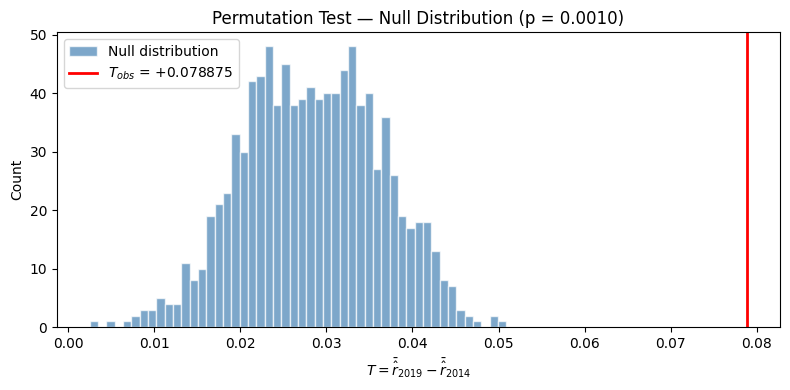

In [106]:
# Null distribution visualization
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_T, bins=50, edgecolor='white', alpha=0.7, color='steelblue', label='Null distribution')
ax.axvline(T_obs, color='red', lw=2, label=f'$T_{{obs}}$ = {T_obs:+.6f}')
ax.set_xlabel('$T = \\bar{\\hat{r}}_{2019} - \\bar{\\hat{r}}_{2014}$')
ax.set_ylabel('Count')
ax.set_title(f'Permutation Test — Null Distribution (p = {p_global:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

## Stage B: Per-Community-Area Tests

If the global test rejects, a natural follow-up: **in which areas** did tipping behavior change?

For each community area $j = 1, \ldots, m$:
1. Subset to rides from area $j$
2. Fit a local regression (same covariates, no year), compute residuals
3. Run the same doubly-robust local permutation test (bins = 10% quantiles of fare, same as Stage A)
4. Obtain p-value $p_j$

**Assumptions for multiple testing (Lecture 3-5):**
- **(B1) Valid p-values:** Each $p_j$ is super-uniform under $H_0$, guaranteed by double robustness (A1 or A2)
- **(B2) Independence across areas:** P-values for different areas use disjoint subsets of rides (rides are assigned to a single pickup area), so $p_1, \ldots, p_m$ are independent
- **(B3) Sufficient sample size:** Each area needs enough rides in both years for the permutation test to have resolution. We require $\geq 50$ rides per year per area.

In [107]:
# Chicago community area names
CA_NAMES = {
    1: "Rogers Park", 2: "West Ridge", 3: "Uptown", 4: "Lincoln Square",
    5: "North Center", 6: "Lake View", 7: "Lincoln Park", 8: "Near North Side",
    9: "Edison Park", 10: "Norwood Park", 11: "Jefferson Park",
    12: "Forest Glen", 13: "North Park", 14: "Albany Park",
    15: "Portage Park", 16: "Irving Park", 17: "Dunning",
    18: "Montclare", 19: "Belmont Cragin", 20: "Hermosa",
    21: "Avondale", 22: "Logan Square", 23: "Humboldt Park",
    24: "West Town", 25: "Austin", 26: "West Garfield Park",
    27: "East Garfield Park", 28: "Near West Side", 29: "North Lawndale",
    30: "South Lawndale", 31: "Lower West Side", 32: "Loop",
    33: "Near South Side", 34: "Armour Square", 35: "Douglas",
    36: "Oakland", 37: "Fuller Park", 38: "Grand Boulevard",
    39: "Kenwood", 40: "Washington Park", 41: "Hyde Park",
    42: "Woodlawn", 43: "South Shore", 44: "Chatham",
    45: "Avalon Park", 46: "South Chicago", 47: "Burnside",
    48: "Calumet Heights", 49: "Roseland", 50: "Pullman",
    51: "South Deering", 52: "East Side", 53: "West Pullman",
    54: "Riverdale", 55: "Hegewisch", 56: "Garfield Ridge",
    57: "Archer Heights", 58: "Brighton Park", 59: "McKinley Park",
    60: "Bridgeport", 61: "New City", 62: "West Elsdon",
    63: "Gage Park", 64: "Clearing", 65: "West Lawn",
    66: "Chicago Lawn", 67: "West Englewood", 68: "Englewood",
    69: "Greater Grand Crossing", 70: "Ashburn", 71: "Auburn Gresham",
    72: "Beverly", 73: "Washington Heights", 74: "Mount Greenwood",
    75: "Morgan Park", 76: "O'Hare", 77: "Edgewater",
}

MIN_PER_YEAR = 50

# Drop rows with missing pickup area
df_cc = df_cc.dropna(subset=['pickup_community_area'])
df_cc['pickup_community_area'] = df_cc['pickup_community_area'].astype(int)

# Check which areas qualify
area_counts = df_cc.groupby(['pickup_community_area', 'year']).size().unstack(fill_value=0)
qualified = area_counts[(area_counts[2014] >= MIN_PER_YEAR) & (area_counts[2019] >= MIN_PER_YEAR)]
print(f"Areas with >= {MIN_PER_YEAR} rides in both years: {len(qualified)} / {df_cc['pickup_community_area'].nunique()}")
print(f"Total rides in qualified areas: {df_cc[df_cc['pickup_community_area'].isin(qualified.index)].shape[0]:,}")

Areas with >= 50 rides in both years: 21 / 70
Total rides in qualified areas: 166,089


In [108]:
# ── Per-area doubly-robust local permutation tests ──

def local_perm_test(data, confounders=CONFOUNDERS, m_perm=M_PERM, rng=rng):
    """
    Doubly-robust local permutation test for a single area.
    
    Returns dict with T_obs, p_value, sample sizes, raw effect, null distribution.
    """
    Y_loc = data['tips'].values
    T_loc = data['year_dummy'].values
    
    # Local regression (same covariates, no year)
    X_loc = data[confounders].copy().reset_index(drop=True)
    X_loc.insert(0, 'const', 1.0)
    
    try:
        model = sm.OLS(Y_loc, X_loc).fit()
        resid = model.resid
    except Exception:
        return None
    
    # Local bins: same as Stage A — 10% quantiles of fare
    try:
        fare_deciles = pd.qcut(data['fare'], q=10, labels=False, duplicates='drop')
    except ValueError:
        fare_deciles = pd.qcut(data['fare'], q=2, labels=False, duplicates='drop')
    bin_codes_loc = fare_deciles
    
    # Pre-compute bin indices (bins with both years)
    local_bin_idx = {}
    for b in np.unique(bin_codes_loc):
        idx = np.where(bin_codes_loc == b)[0]
        if len(np.unique(T_loc[idx])) == 2:
            local_bin_idx[b] = idx
    
    # Observed test statistic
    T_obs_loc = resid[T_loc == 1].mean() - resid[T_loc == 0].mean()
    
    # Permutation null
    null_vals = np.empty(m_perm)
    for i in range(m_perm):
        sh = T_loc.copy()
        for b, idx in local_bin_idx.items():
            block = sh[idx]
            rng.shuffle(block)
            sh[idx] = block
        null_vals[i] = resid[sh == 1].mean() - resid[sh == 0].mean()
    
    p_val = (1 + np.sum(np.abs(null_vals) >= np.abs(T_obs_loc))) / (1 + m_perm)
    
    effect_raw = Y_loc[T_loc == 1].mean() - Y_loc[T_loc == 0].mean()
    
    return {
        'T_obs': T_obs_loc,
        'p_value': p_val,
        'n_2014': int((T_loc == 0).sum()),
        'n_2019': int((T_loc == 1).sum()),
        'effect_raw': effect_raw,
        'null_dist': null_vals,
    }

# Run for all qualified areas
results = []
for area in qualified.index:
    subset = df_cc[df_cc['pickup_community_area'] == area].copy().reset_index(drop=True)
    out = local_perm_test(subset)
    if out is None:
        continue
    out['area_id'] = area
    out['area_name'] = CA_NAMES.get(area, f'Area {area}')
    results.append(out)
    
print(f"Successfully tested {len(results)} areas")

Successfully tested 21 areas


## Stage C: Benjamini-Hochberg + FCR-controlling Confidence Intervals

### BH Procedure (Lecture 3, Proposition 1.3.2)

Sort p-values: $p_{(1)} \leq \cdots \leq p_{(m)}$. Reject $p_{(1)}, \ldots, p_{(\hat k)}$ where $\hat k = \max\{k : p_{(k)} \leq \frac{\alpha k}{m}\}$.

By Theorem 1.3.3, if p-values are independent (which holds here since areas use disjoint data), BH controls $\text{FDR} \leq \alpha \cdot m_0/m \leq \alpha$.

### FCR-controlling CIs (Lecture 6, Theorem 1.4.1)

For each BH discovery, report a confidence interval at level $1 - \alpha \hat k / m$ (not the usual $1 - \alpha$). This ensures:
$$\text{FCR} = \mathbb{E}\left[\frac{\text{\# reported CIs that fail to cover}}{\max(1, \hat k)}\right] \leq \alpha$$

**Assumptions for FCR control (Theorem 1.4.1):**
- **(C1)** Data for each area is independent — holds since rides have a single pickup area
- **(C2)** $\hat k = \hat k_{-i}$ for discovered $i$ — holds automatically for BH (Lemma from Lecture 6)
- **(C3)** Each CI is a valid CI at the specified level — we use bootstrap percentile CIs

In [109]:
# ── BH procedure ──

res_df = pd.DataFrame([{
    'area_id': r['area_id'],
    'area_name': r['area_name'],
    'n_2014': r['n_2014'],
    'n_2019': r['n_2019'],
    'n': r['n_2014'] + r['n_2019'],
    'T_obs': r['T_obs'],
    'effect_raw': r['effect_raw'],
    'raw_p': r['p_value'],
} for r in results])

res_df = res_df.sort_values('raw_p').reset_index(drop=True)
m = len(res_df)
res_df['rank'] = np.arange(1, m + 1)
res_df['bh_threshold'] = res_df['rank'] / m * ALPHA

# BH: reject all p_(k) where p_(k) <= alpha * k / m, up to max such k
res_df['bh_reject'] = res_df['raw_p'] <= res_df['bh_threshold']
if res_df['bh_reject'].any():
    k_hat = res_df[res_df['bh_reject']].index.max() + 1  # +1 because 0-indexed
    res_df.loc[:res_df[res_df['bh_reject']].index.max(), 'bh_reject'] = True
else:
    k_hat = 0

# BH-adjusted p-values
res_df['bh_adj_p'] = np.minimum(res_df['raw_p'] * m / res_df['rank'], 1.0)
res_df['bh_adj_p'] = res_df['bh_adj_p'][::-1].cummin()[::-1]

print(f"Number of hypotheses (m): {m}")
print(f"BH discoveries (k_hat):   {k_hat}")
print(f"FDR control level:        {ALPHA}")
if k_hat > 0:
    print(f"\nFCR CI level: 1 - alpha * k_hat / m = 1 - {ALPHA} * {k_hat} / {m} = {1 - ALPHA * k_hat / m:.4f}")

Number of hypotheses (m): 21
BH discoveries (k_hat):   3
FDR control level:        0.05

FCR CI level: 1 - alpha * k_hat / m = 1 - 0.05 * 3 / 21 = 0.9929


In [110]:
# ── FCR-controlling bootstrap CIs for discoveries ──

N_BOOT = 2000

if k_hat > 0:
    fcr_alpha = ALPHA * k_hat / m  # CI level = 1 - fcr_alpha
    ci_lo_pct = 100 * fcr_alpha / 2
    ci_hi_pct = 100 * (1 - fcr_alpha / 2)
    
    ci_results = []
    for _, row in res_df[res_df['bh_reject']].iterrows():
        area = row['area_id']
        subset = df_cc[df_cc['pickup_community_area'] == area].copy().reset_index(drop=True)
        
        tips_loc = subset['tips'].values
        year_loc = subset['year_dummy'].values
        
        # Stratified bootstrap: resample within each year to preserve year counts
        idx_2014 = np.where(year_loc == 0)[0]
        idx_2019 = np.where(year_loc == 1)[0]
        
        boot_effects = np.empty(N_BOOT)
        for b in range(N_BOOT):
            b14 = rng.choice(idx_2014, size=len(idx_2014), replace=True)
            b19 = rng.choice(idx_2019, size=len(idx_2019), replace=True)
            boot_effects[b] = tips_loc[b19].mean() - tips_loc[b14].mean()
        
        ci_lo = np.percentile(boot_effects, ci_lo_pct)
        ci_hi = np.percentile(boot_effects, ci_hi_pct)
        ci_results.append({'area_id': area, 'ci_lo': ci_lo, 'ci_hi': ci_hi})
    
    ci_df = pd.DataFrame(ci_results)
    res_df = res_df.merge(ci_df, on='area_id', how='left')
    
    print(f"FCR-controlling CI level: {1 - fcr_alpha:.4f} (i.e., {ci_hi_pct - ci_lo_pct:.2f}% intervals)")
else:
    res_df['ci_lo'] = np.nan
    res_df['ci_hi'] = np.nan
    print("No BH discoveries — no CIs to compute.")

FCR-controlling CI level: 0.9929 (i.e., 99.29% intervals)


# 3. Results

In [111]:
# ── Results table ──
display_cols = ['area_name', 'n', 'effect_raw', 'T_obs', 'raw_p', 'bh_adj_p', 'bh_reject']
if k_hat > 0:
    display_cols += ['ci_lo', 'ci_hi']

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
res_df[display_cols]

,area_name,n,effect_raw,T_obs,raw_p,bh_adj_p,bh_reject,ci_lo,ci_hi
0,Near North Side,51765,0.0111,0.0666,0.0010,0.0105,True,-0.0347,0.0646
1,O'Hare,18564,1.5197,0.2225,0.0010,0.0105,True,1.3967,1.6305
2,Near West Side,16324,-0.0773,0.0652,0.0060,0.0420,True,-0.1568,-0.0032
3,Lake View,7983,0.4290,0.0710,0.0240,0.1259,False,NaN,NaN
4,Garfield Ridge,5134,1.2749,0.2002,0.0360,0.1510,False,NaN,NaN
5,North Center,483,1.1404,0.2603,0.0929,0.3252,False,NaN,NaN
6,Hyde Park,686,0.8331,0.2174,0.1399,0.3543,False,NaN,NaN
7,Uptown,1579,0.4451,0.1087,0.1469,0.3543,False,NaN,NaN
8,Armour Square,141,1.0332,0.3324,0.1518,0.3543,False,NaN,NaN
9,Irving Park,265,0.9957,-0.2570,0.2647,0.4790,False,NaN,NaN


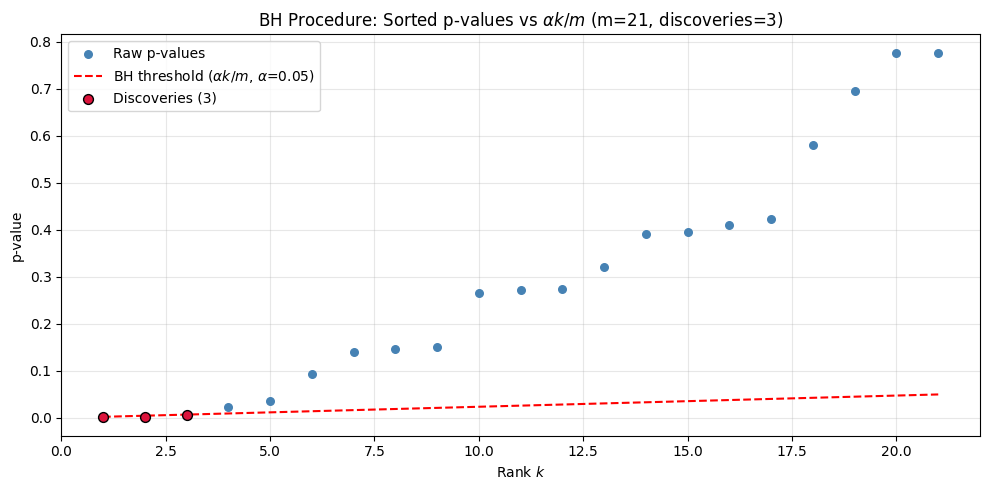

In [112]:
# ── BH staircase plot: sorted p-values vs thresholds ──
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(res_df['rank'], res_df['raw_p'], color='steelblue', s=30, zorder=3, label='Raw p-values')
ax.plot(res_df['rank'], res_df['bh_threshold'], color='red', ls='--', lw=1.5, 
        label=f'BH threshold ($\\alpha k / m$, $\\alpha$={ALPHA})')

if k_hat > 0:
    ax.scatter(res_df[res_df['bh_reject']]['rank'], 
               res_df[res_df['bh_reject']]['raw_p'],
               color='crimson', s=50, zorder=4, edgecolors='black', label=f'Discoveries ({k_hat})')

ax.set_xlabel('Rank $k$')
ax.set_ylabel('p-value')
ax.set_title(f'BH Procedure: Sorted p-values vs $\\alpha k / m$ (m={m}, discoveries={k_hat})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

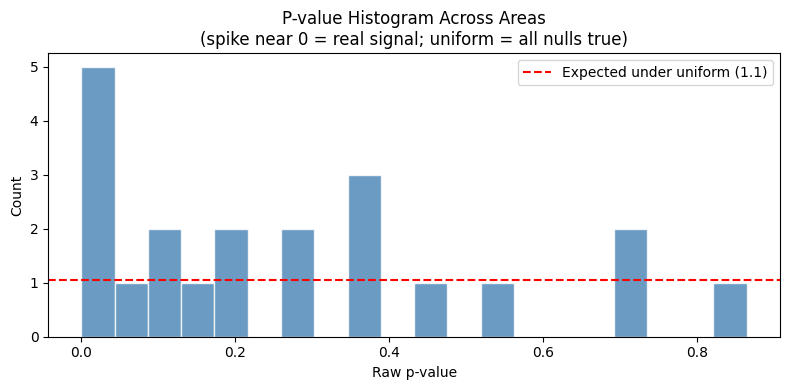

In [78]:
# ── P-value histogram (diagnostic: should be uniform under global null) ──
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res_df['raw_p'], bins=20, edgecolor='white', color='steelblue', alpha=0.8)
ax.axhline(m / 20, color='red', ls='--', lw=1.5, label=f'Expected under uniform ({m/20:.1f})')
ax.set_xlabel('Raw p-value')
ax.set_ylabel('Count')
ax.set_title('P-value Histogram Across Areas\n(spike near 0 = real signal; uniform = all nulls true)')
ax.legend()
plt.tight_layout()
plt.show()

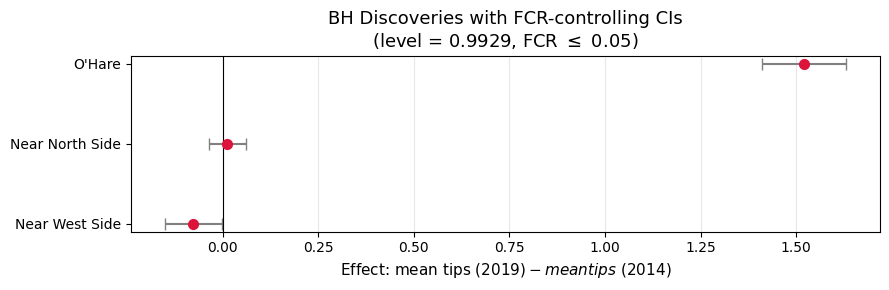

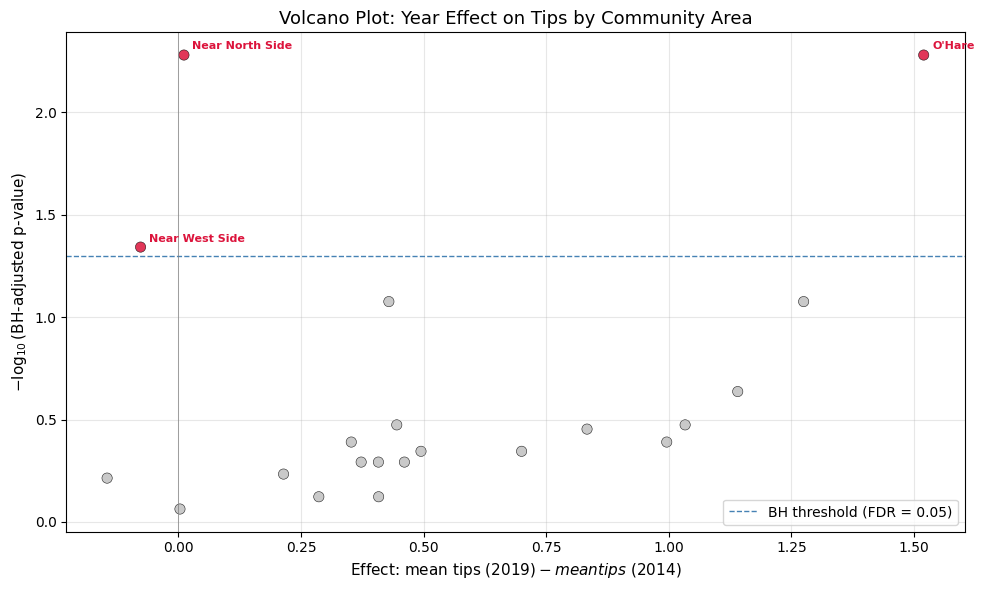

In [79]:
# ── Forest plot with FCR-controlling CIs ──
if k_hat > 0:
    sig = res_df[res_df['bh_reject']].sort_values('effect_raw').copy()
    
    fig, ax = plt.subplots(figsize=(9, max(3, len(sig) * 0.5 + 1)))
    y_pos = np.arange(len(sig))
    
    ax.errorbar(
        sig['effect_raw'], y_pos,
        xerr=[sig['effect_raw'] - sig['ci_lo'], sig['ci_hi'] - sig['effect_raw']],
        fmt='o', color='crimson', ecolor='gray', elinewidth=1.5,
        capsize=4, markersize=7
    )
    ax.axvline(0, color='black', ls='-', lw=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sig['area_name'], fontsize=10)
    ax.set_xlabel('Effect: mean tips $ (2019) - mean tips $ (2014)', fontsize=11)
    ax.set_title(f'BH Discoveries with FCR-controlling CIs\n'
                 f'(level = {1 - fcr_alpha:.4f}, FCR $\\leq$ {ALPHA})', fontsize=13)
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No BH discoveries to plot.")

# ── Volcano plot ──
fig, ax = plt.subplots(figsize=(10, 6))
neg_log_p = -np.log10(np.clip(res_df['bh_adj_p'].values, 1e-10, 1.0))
colors = np.where(res_df['bh_reject'].values, 'crimson', 'silver')

ax.scatter(res_df['effect_raw'].values, neg_log_p,
           c=colors, s=55, alpha=0.85, edgecolors='k', linewidths=0.4)
ax.axhline(-np.log10(ALPHA), color='steelblue', ls='--', lw=1, label=f'BH threshold (FDR = {ALPHA})')
ax.axvline(0, color='gray', ls='-', lw=0.5)

# Label significant areas
for _, row in res_df[res_df['bh_reject']].iterrows():
    y = -np.log10(max(row['bh_adj_p'], 1e-10))
    ax.annotate(row['area_name'], (row['effect_raw'], y),
                textcoords='offset points', xytext=(6, 4),
                fontsize=8, color='crimson', fontweight='bold')

ax.set_xlabel('Effect: mean tips $ (2019) - mean tips $ (2014)', fontsize=11)
ax.set_ylabel('$-\\log_{10}$(BH-adjusted p-value)', fontsize=11)
ax.set_title('Volcano Plot: Year Effect on Tips by Community Area', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Discussion & Limitations

### What double robustness provides
The test is valid if **either** (A1) the local permutation bins are fine-grained enough that $P(\text{Year} \mid Z)$ is approximately constant within each bin, **or** (A2) the OLS regression correctly captures the relationship between confounders and tip percentage. This means:
- If the regression is misspecified (e.g., the true relationship is nonlinear), the local permutation still provides valid p-values as long as the bins are adequate.
- If the bins are too coarse (e.g., fare quartiles group rides with very different fare levels), the regression residuals still remove confounders if the model is correct.

### Bin granularity tradeoff (Lecture 8)
Smaller bins improve A1 validity but reduce the number of permutations available within each bin, reducing statistical power. In the extreme, if each bin contains only one observation, the only valid permutation is the identity and the p-value is 1. Conversely, larger bins allow more permutations (higher power) but increase the risk that $P(\text{Year} \mid Z)$ varies within a bin, violating A1. We chose 4 fare quartiles $\times$ 4 hour blocks = 16 bins as a balance.

### Independence of p-values across areas (B2)
Since each ride is assigned to a single pickup community area, the per-area tests use disjoint subsets of the data. This makes the p-values $p_1, \ldots, p_m$ independent, which is the strongest assumption under which BH controls FDR $\leq \alpha \cdot m_0/m$ (Theorem 1.3.3). Under arbitrary dependence, BH would still control FDR $\leq \alpha \cdot \log(m)$ (Theorem 1.3.5), but independence gives the tighter bound.

### Remaining confounders that cannot be addressed
- **Ride-sharing entry:** Uber and Lyft expanded significantly in Chicago between 2014 and 2019, changing the composition of who takes taxis. If ride-sharing selectively drew away passengers who tip less (or more), this would show up as a tipping change even without any individual changing behavior. This is an unobservable confounder.
- **Credit card selection bias:** Restricting to credit card rides may introduce selection bias if the type of person paying by credit card shifted between years (e.g., due to mobile payment options appearing in 2019).
- **Driver behavior:** Changes in driver friendliness, route choice, or app-based tipping prompts could affect tipping rates but are not recorded in the data.

### Power limitations
- Small community areas with few credit-card rides may lack power to detect real effects. The minimum threshold of 50 rides per year is conservative.
- The permutation p-value has resolution $1/(M+1)$; with $M = 2000$, the smallest possible p-value is $\approx 0.0005$. Very strong effects may be "floored" at this resolution.